In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import load_model, Model
#from tensorflow.keras.utils import layer_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import keras
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#reading the csv file
data = pd.read_csv("labels.csv")
#store training and testing images folder location
train_file = 'E:/Prajwal/MIT notes/AeroMIT/ADR TaskPhase/DL/DogBreed/train'
test_file = 'E:/Prajwal/MIT notes/AeroMIT/ADR TaskPhase/DL/DogBreed/test'

In [ ]:
data.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
print("Total number of unique Dog Breeds :",len(data.breed.unique())) 

Total number of unique Dog Breeds : 120


In [ ]:

individual = data.breed.value_counts()
print(individual)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


In [ ]:
#specifying the number of breeds to consider for the model as taking all 120 would affect computation
num_breeds = 5
im_size = 224
batch_size = 32
encoder = LabelEncoder()

In [ ]:
#get only 60 unique breeds record 
breed_dict = list(data['breed'].value_counts().keys()) 
new_list = sorted(breed_dict,reverse=True)[:num_breeds*2:2]
#change the dataset to have only those 60 unique breed records
data = data.query('breed in @new_list')

In [ ]:
new_list

['yorkshire_terrier',
 'whippet',
 'welsh_springer_spaniel',
 'walker_hound',
 'toy_terrier']

In [ ]:
len(new_list)

5

In [ ]:
#creating new column which will contain image name with the image extension
data['img_file'] = data['id'].apply(lambda x: x + ".jpg")

In [ ]:
data.head()

id  ...                              img_file
11   0067dc3eab0b3c3ef0439477624d85d6  ...  0067dc3eab0b3c3ef0439477624d85d6.jpg
34   00f34ac0a16ef43e6fd1de49a26081ce  ...  00f34ac0a16ef43e6fd1de49a26081ce.jpg
52   015b363b062f602e7ec04ce28e640d05  ...  015b363b062f602e7ec04ce28e640d05.jpg
83   01f8540fb1084107a6eb3e528f82c1aa  ...  01f8540fb1084107a6eb3e528f82c1aa.jpg
123  02ef5f19db8cf4da62016a1067bdc548  ...  02ef5f19db8cf4da62016a1067bdc548.jpg

[5 rows x 3 columns]

In [ ]:
len(data.breed.unique())

5

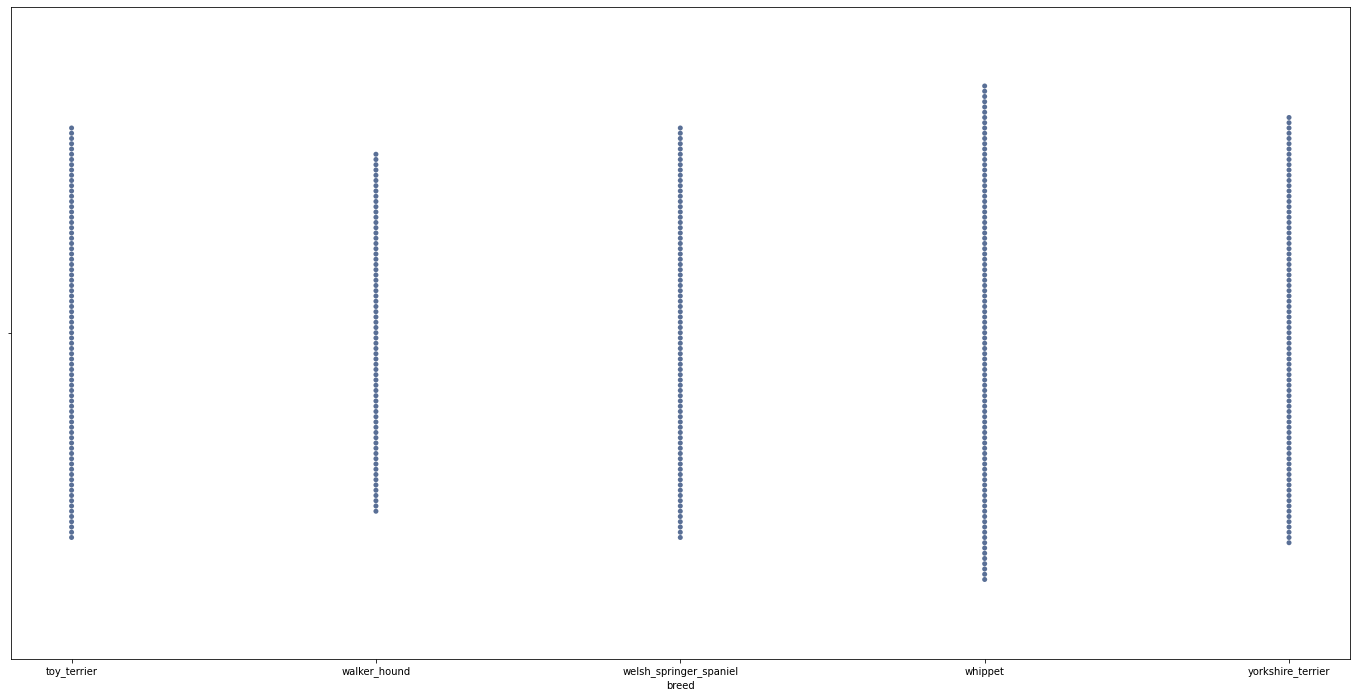

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))
sns.swarmplot(data['breed'], color='#2f4b7c', alpha=0.8, ax=ax)

In [ ]:
'''
#creating a numpy array of the shape
#syntax is (number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = (len(data), im_size, im_size, 3)
#train_x = np.zeros(x, dtype=float)
#print(train_x)
'''

#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(data), im_size, im_size, 3), dtype='float32')
 
#iterate over img_file column of our dataset
for i, img_id in enumerate(data['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
  
  
  if not os.path.isfile(img_id):
    continue
    
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))

  
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
  train_x[i] = img_array

'''
print('There are ', len(data), 'images in the dataset.')
print('The images will be re-shaped to a size of ', im_size, 'pixels per side')
size = (len(data), im_size, im_size, 3)
#matrix_image = list()#np.zeros(size)
breed = list()#np.zeros(len(list_size_x))
size
'''

"\nprint('There are ', len(data), 'images in the dataset.')\nprint('The images will be re-shaped to a size of ', im_size, 'pixels per side')\nsize = (len(data), im_size, im_size, 3)\n#matrix_image = list()#np.zeros(size)\nbreed = list()#np.zeros(len(list_size_x))\nsize\n"

In [ ]:
#This will be the target for the model.
#convert breed names into numerical format
train_y = encoder.fit_transform(data["breed"].values)

In [ ]:
#split the dataset in the ratio of 80:20. 
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [ ]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 

#generate images for training sets 
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
 

#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
#building the model using ResNet50V2 with input shape of our image array
#weights for the network will be from imagenet dataset
#not to include the first Dense layer
resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)
#freezing all trainable layers and train only top layers 
for layer in resnet.layers:
    layer.trainable = False
 
#adding global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
#adding fully connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

'''
x = resnet.output
x = Flatten()(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.6)(x)
#clf.add(Dense(units=120,activation='softmax')
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
#clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
predictions = Dense(120, activation='softmax')(x)
'''

94683136/94668760 [==============================] - 1s 0us/step


"\nx = resnet.output\nx = Flatten()(x)\nx=Dropout(0.25)(x)\nx=Dense(units=1000,activation='relu')(x)\nx=Dropout(0.25)(x)\nx=Dense(units=750,activation='relu')(x)\nx=Dropout(0.25)(x)\nx=Dense(units=750,activation='relu')(x)\nx=Dropout(0.25)(x)\nx=Dense(units=750,activation='relu')(x)\nx=Dropout(0.25)(x)\nx=Dense(units=1000,activation='relu')(x)\nx=Dropout(0.6)(x)\n#clf.add(Dense(units=120,activation='softmax')\n#stochastic gradient descent -Adam -optimizer\n#loss func categorical cross entropy\n#metrics = accuracy\n#clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])\npredictions = Dense(120, activation='softmax')(x)\n"

In [ ]:
#adding output layer having the shape equal to number of breeds
predictions = Dense(num_breeds, activation='softmax')(x)
 
#creating model class with inputs and outputs
model = Model(inputs=resnet.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
#epochs for model training and learning rate for the optimizer
epochs = 30
learning_rate = 1e-3
 
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
 
#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= (x_test.shape[0] // batch_size) +1)
 
#Save the model for prediction
model.save("model")

Epoch 1/30
10/10 [==============================] - 50s 5s/step - loss: 1.6098 - accuracy: 0.1959 - val_loss: 1.6672 - val_accuracy: 0.1852
Epoch 2/30
10/10 [==============================] - 47s 5s/step - loss: 1.6127 - accuracy: 0.2371 - val_loss: 1.6435 - val_accuracy: 0.1852
Epoch 3/30
10/10 [==============================] - 46s 5s/step - loss: 1.6035 - accuracy: 0.2062 - val_loss: 1.6372 - val_accuracy: 0.1852
Epoch 4/30
10/10 [==============================] - 49s 5s/step - loss: 1.6037 - accuracy: 0.2656 - val_loss: 1.6372 - val_accuracy: 0.1852
Epoch 5/30
10/10 [==============================] - 46s 5s/step - loss: 1.6059 - accuracy: 0.2440 - val_loss: 1.6342 - val_accuracy: 0.1852
Epoch 6/30
10/10 [==============================] - 46s 5s/step - loss: 1.6017 - accuracy: 0.2371 - val_loss: 1.6302 - val_accuracy: 0.1852
Epoch 7/30
10/10 [==============================] - 46s 5s/step - loss: 1.6003 - accuracy: 0.2612 - val_loss: 1.6301 - val_accuracy: 0.1852
Epoch 8/30
10/10 [==

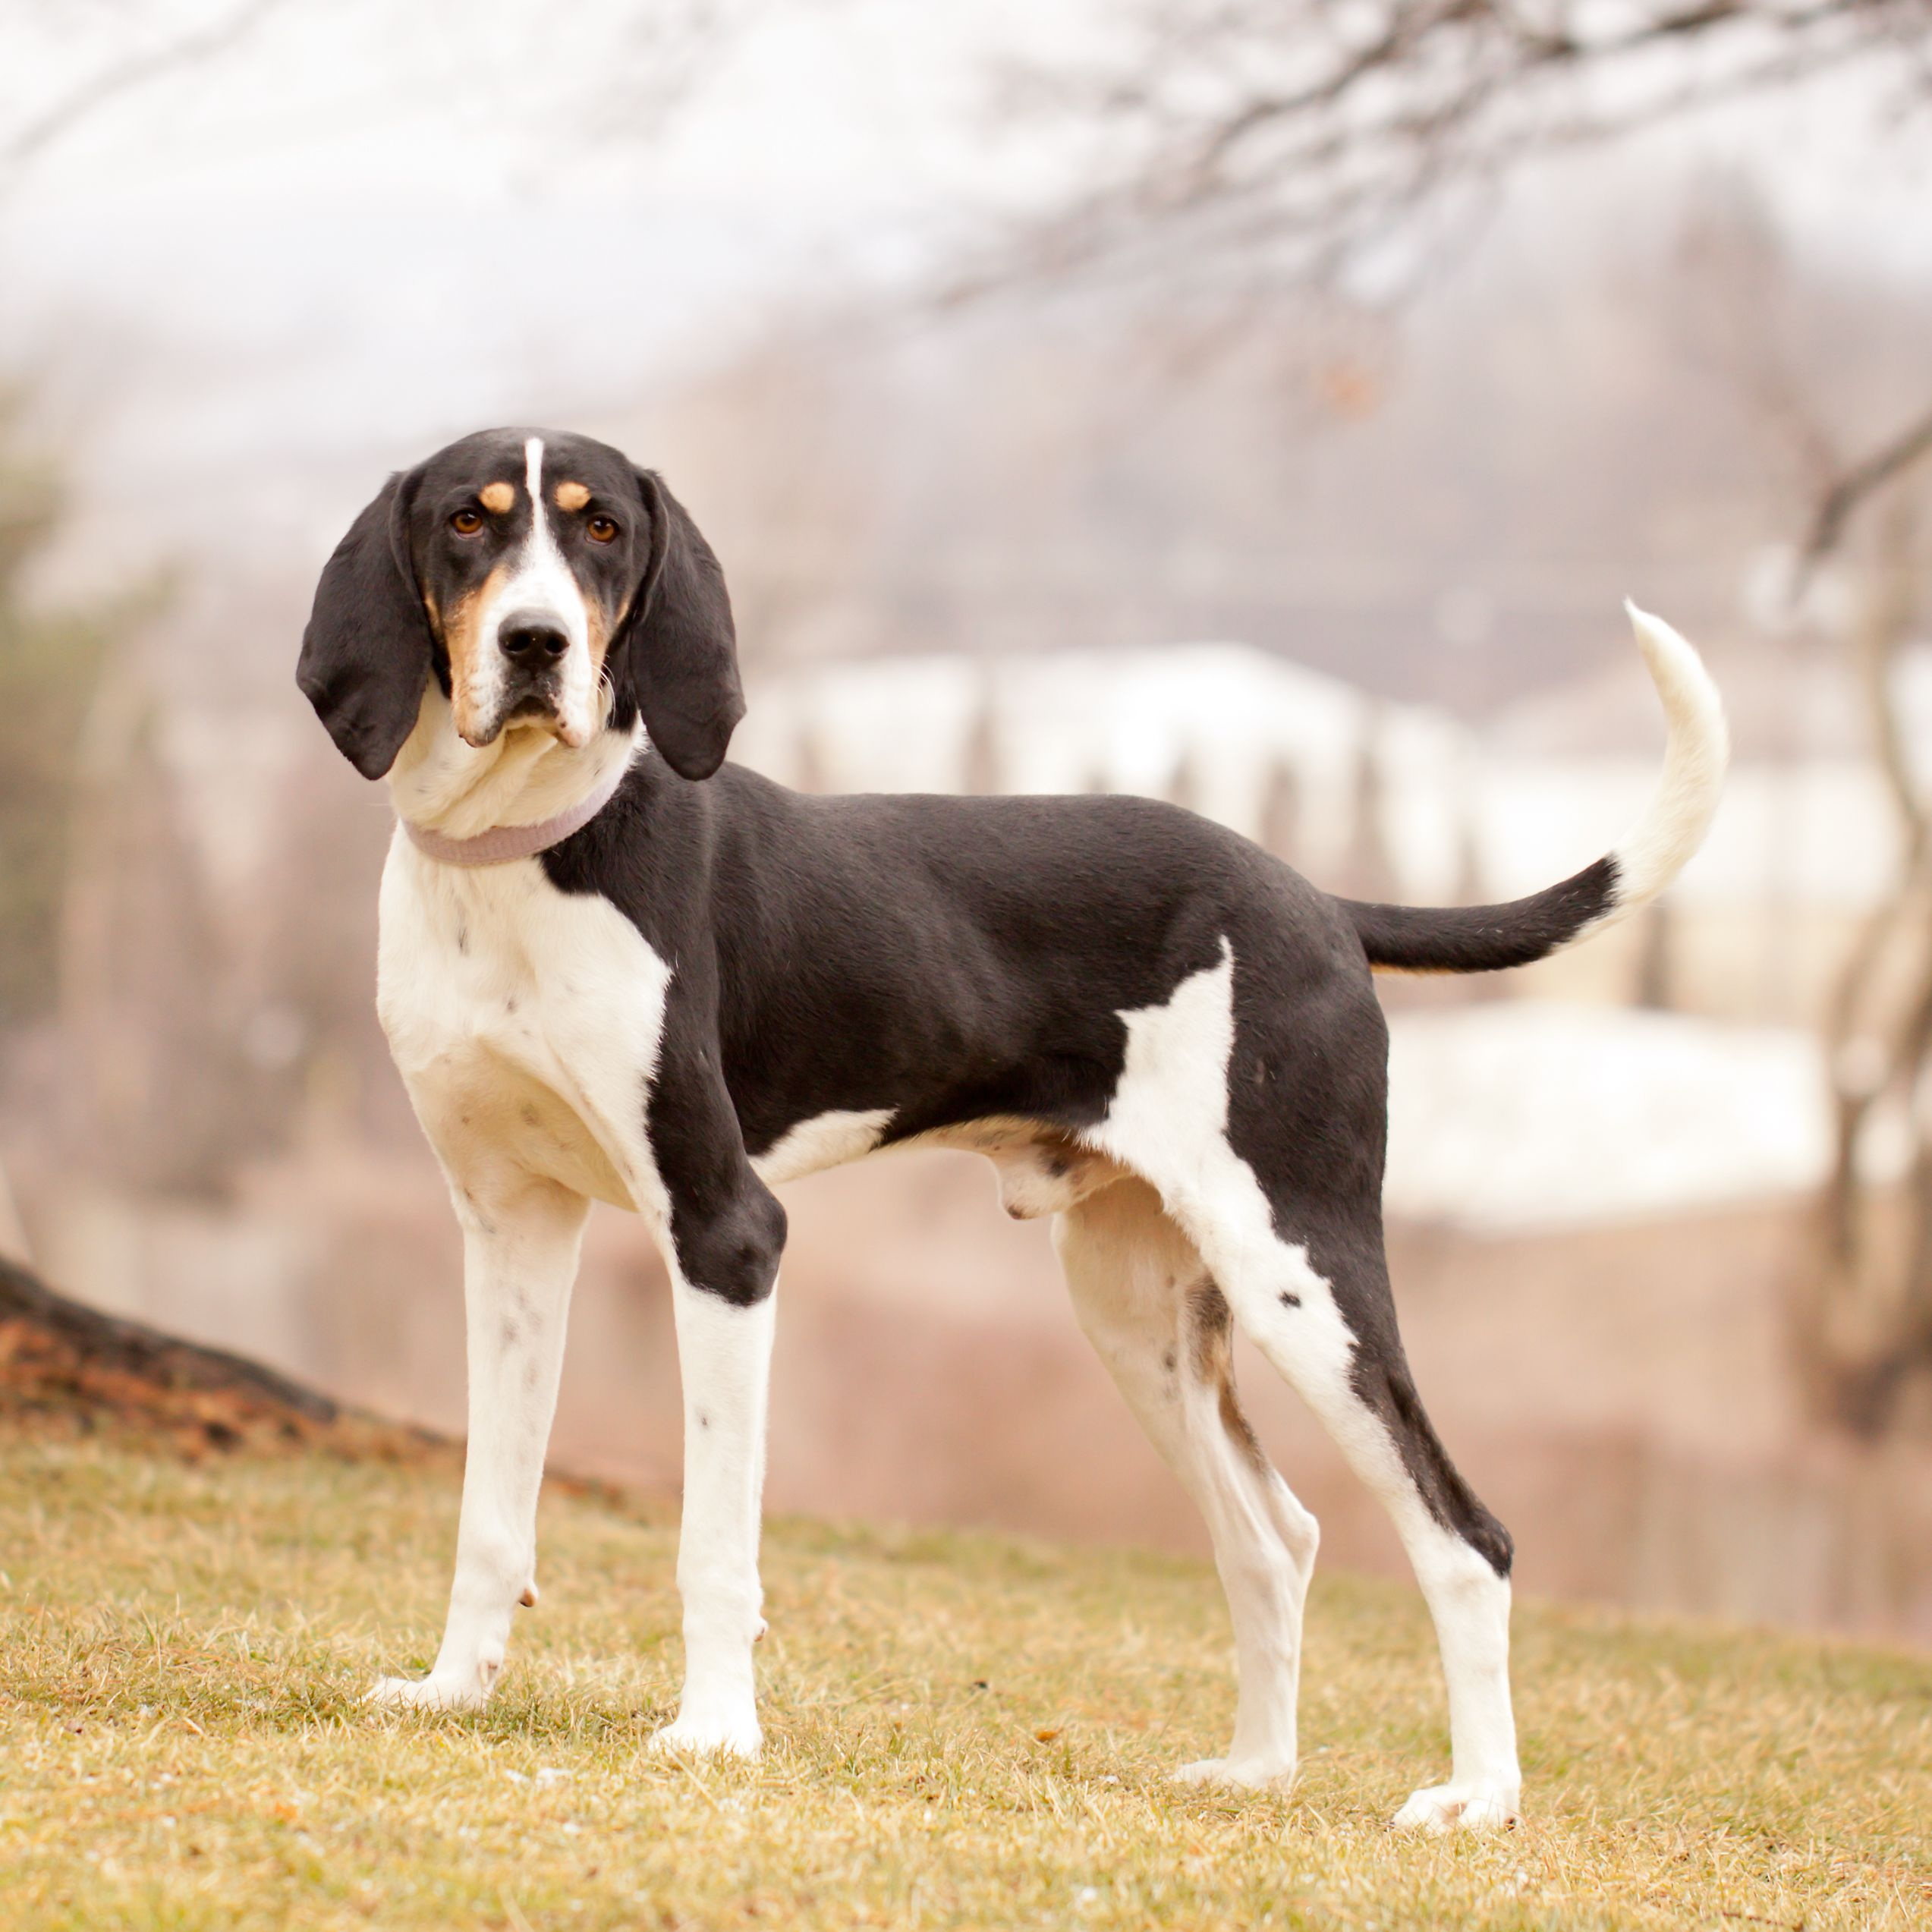

Predicted Breed for this Dog is : walker_hound


In [ ]:
#load the model
model = load_model("model")
 
#get the image of the dog for prediction
pred_img_path = 'hound.jpg'
abc = cv2.imread(pred_img_path,cv2.IMREAD_COLOR)
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
##def path_to(pred_img_path):
img = image.load_img(pred_img_path, target_size=(224,224))
x = image.img_to_array(img)
  ##return np.expand_dims(x, axis=0)


##for pred_img_path in enumerate(data['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
  
  ##if not os.path.isfile(pred_img_path):
    ##continue
    ##pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1
#expand the dimension on the axis 0 and normalize the array values
    ##pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
##pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

pred_val = model.predict(np.expand_dims(x, axis=0))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(abc)
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)